<h1 style="color: #001a79;">Machine Learning Project Notebook</h1>

<h3 style="color: #001a79;">For this notebook you will need the following packages:</h3>

In [1]:
# Efficient numerical arrays.
import numpy as np

# Dataframes for data manipulation and analysis.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting.
import matplotlib.pyplot as plt

# Fancier plotting.
import seaborn as sns

# Plotting dates.
import matplotlib.dates as mdates

**Note**: I had trouble with Keras running on my machine. You may not need to run the next line. The solution was found on Stackoverflow <a href="https://stackoverflow.com/a/29533344" target="_blank">here</a>

In [2]:
import os
# Fixed issue I was having running the notebook. 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<h3 style="color: #001a79;">Introduction</h3>

<hr style="border-top: 1px solid #001a79;" />

Detecting anomalies in datasets has broad applications in a lot of domains.  Use cases such as preventative maintenance, fraud
prevention, fault detection, and monitoring can be found throughout numerous industries such as finance, IT, security,
medical, energy, e-commerce, and social media. Due to it's wide range of appications the problem of anomaly detection has been thoroughly reseached amongst industry specialists and academics. Several algorithms have been introduced for determining anomalies in problem settings. However, there were no datasets or framework that was openly availible which the proposed algorithms could be evaluated on a common ground. This changed with the introduction of the Numenta Anomaly Benchmark (NAB) Framework in 2015.  

The Numenta Anomaly Benchmark (NAB) Framework is an open source framework with extensive documentation, and a scoreboard of anomaly detection algorithms found <a href="https://github.com/numenta/NAB" target="_blank">here</a>. It contains labeled data files which comprise of over 50 labeled real-world and artificial timeseries data files and a common scoring system to compare and evaluate different anomaly detection algorithms for detecting anomalies in streaming data. Streaming data anomalies (which can also be refered to as outliers) are patterns that do not match with previous patterns of behaviour for the given data stream. 

In this notebook we will use an anomaly detection algorithm on one of the NAB datasets. This notebook is based off <a href="https://keras.io/examples/timeseries/timeseries_anomaly_detection/" target="_blank">Keras: Time series anomaly detection using an Autoencoder</a> blog post. 

Sources: <br> 
<a href="https://www.youtube.com/watch?v=QPQA9X5-V0g&ab_channel=fintelics" target="_blank">Fintelics (YouTube): Everything You Need to Know About Numenta Anomaly Benchmark (NAB)</a><br>
<a href="https://www.kaggle.com/datasets/boltzmannbrain/nab" target="_blank">Kaggle: Numenta Anomaly Benchmark (NAB)</a>

<h3 style="color: #001a79;">Loading the Data</h3>

<hr style="border-top: 1px solid #001a79;" />

To demonstrate anomaly detection effectively we will use two datasets from the Numenta Anomaly Benchmark (NAB) artificially generated datasets. 

The algorithm we will use to for the anomaly detection is the convolutional reconstruction autoencoder model. It uses:

1. <a href="https://github.com/numenta/NAB/blob/master/data/artificialNoAnomaly/art_daily_small_noise.csv" target="_blank">`art_daily_small_noise.csv`</a> - **to train the model (which has no anomalies) - `df_train`**. 
2. <a href="https://github.com/numenta/NAB/blob/master/data/artificialWithAnomaly/art_daily_jumpsup.csv" target="_blank">`the art_daily_jumpsup.csv`</a> - **to test the model (which has anomalies) - `df_test`**. 

In [3]:
# These CSVs can be found at the follow URL.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'
root_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/'

### `df_train`

In [4]:
# art_daily_small_noise.csv data file url.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [5]:
# Import and save data as a df - df_train. 
# parse_dates=True will tell pandas you are importing a date while index_col="timestamp" sets timestamp as the index. 
df_train = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

# Print 
df_train

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [6]:
# Print min value
df_train.min()

value    18.000964
dtype: float64

In [7]:
# Print max value
df_train.max()

value    87.976128
dtype: float64

`df_train` contains 4,032 rows of data with 2 columns `timestamp` (the index) and `value`. 

`timestamp` - Is the dataframes index and represents a **date and time** formatted as Year-Month-Day (YYYY-MM-DD) and Hours:Minutes:Seconds (hh:mm:ss). 

The timestamp starts at the 1st of April 2014 at 12:00am and increments by 5 minutes at each row. The last data point on 14th of April 2014 at 12:55pm. 

Therefore for 14 days, every 5 minutes a value is recorded. 
- Every hour, 12 values are recorded. 
- Every day, 288 values are recorded. 
- So in 14 days, 4,032 values are recorded in total.

`value` - is a value recorded at each timestamp. It is type float with a min of 18.000964 and max 87.976128. 

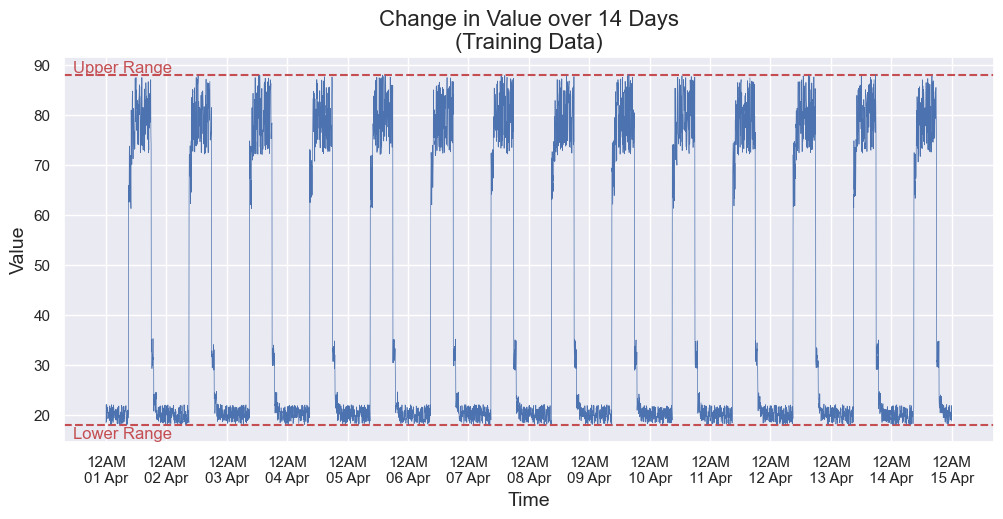

In [8]:
# Graph style
sns.set(style="darkgrid")

# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Change in Value over 14 Days\n(Training Data)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Show red line at values range 
ax.axhline(y = 18, color = 'r', linestyle = '--')
ax.axhline(y = 88, color = 'r', linestyle = '--')

# Plot upper and lower range text. 
plt.text(0.01, .96, 'Upper Range', color = 'r', transform=ax.transAxes)
plt.text(0.01, .01, 'Lower Range', color = 'r', transform=ax.transAxes)

# Plot Value vs Time.
plt.plot(df_train.index, df_train['value'], linewidth=0.5);

We can see value rise and fall over the 14 days in a similiar pattern. Lets look at just one day.

In [9]:
# Get df for day 1
df_train_day1 = df_train.iloc[0:288]
df_train_day1

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-01 23:35:00,18.712206
2014-04-01 23:40:00,20.892275
2014-04-01 23:45:00,18.164629


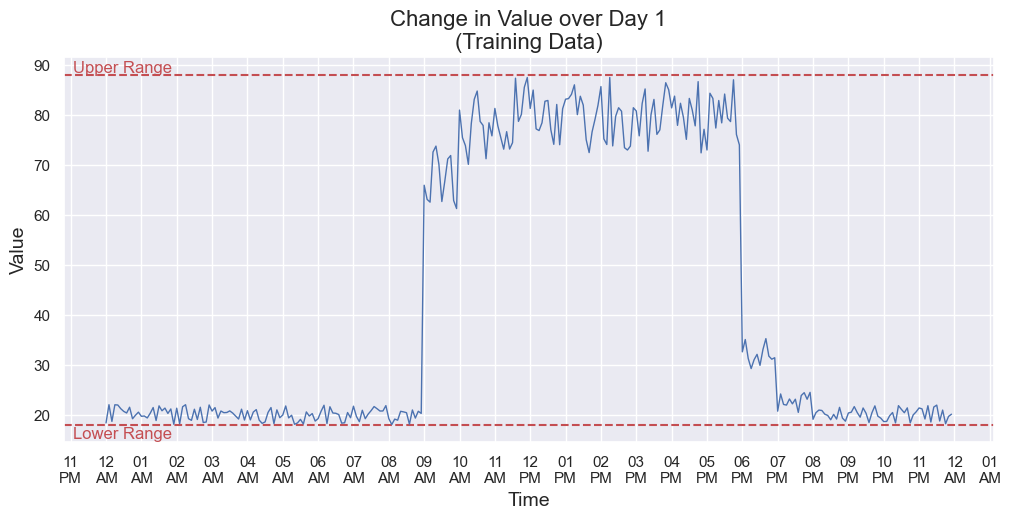

In [10]:
# Graph style
sns.set(style="darkgrid")

# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Change in Value over Day 1\n(Training Data)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("%I\n%p")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.HourLocator())

# Show red line at values range 
ax.axhline(y = 18, color = 'r', linestyle = '--')
ax.axhline(y = 88, color = 'r', linestyle = '--')

# Plot upper and lower range. 
plt.text(0.01, .96, 'Upper Range', color = 'r', transform=ax.transAxes)
plt.text(0.01, .01, 'Lower Range', color = 'r', transform=ax.transAxes)

# Plot Time vs Value
plt.plot(df_train_day1.index, df_train_day1['value'], linewidth=1.0);


We can see that each day has the same pattern. 
- From 12AM - 9AM value fluctuates between 18-22. 
- At 9AM there is a sharp rise in activity to about 65. 
- From 9AM - 10AM value fluctuates between 62-72. 
- From 10AM - 6PM value fluctuates between 70-90. 
- At 6PM there is a sharp drop in value. 
- From 6PM - 7PM value fluctuates between 30-34. 
- At 7PM there is a sharp drop in value. 
- From 7PM - 8PM value fluctuates between 20-24. 
- From 8PM on value fluctuates between 18-24. 

<a href="https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/#:~:text=Using%20the%20DateFormatter%20module%20from,number%20with%20lower%20case%20m" target="_blank">Earth Lab: How to Reformat Date Labels in Matplotlib</a> <br>
<a href="https://www.youtube.com/watch?v=_LWjaAiKaf8&t=889s&ab_channel=CoreySchafer" target="_blank">Corey Schafer (YouTube): Matplotlib Tutorial (Part 8): Plotting Time Series Data</a> <br>
<a href="https://stackoverflow.com/a/63281376" target="_blank">Stackoverflow: Fix plot</a>
<a href="https://docs.python.org/3/library/time.html" target="_blank">Python: Time access and conversions</a>

### `df_test` 

In [11]:
# art_daily_jumpsup.csv data file url.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

# Import and save data as a df - df_daily_jumpsup. 
df_test  = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

# Print 
df_test

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


In [12]:
# Print min value
df_test.min()

value    18.00101
dtype: float64

In [13]:
# Print max value
df_test.max()

value    164.947481
dtype: float64

`df_test` also contains 4,032 rows of data with 2 columns `timestamp` (the index) and `value`. `value` has a min of 18.00101 and max 164.947481. 

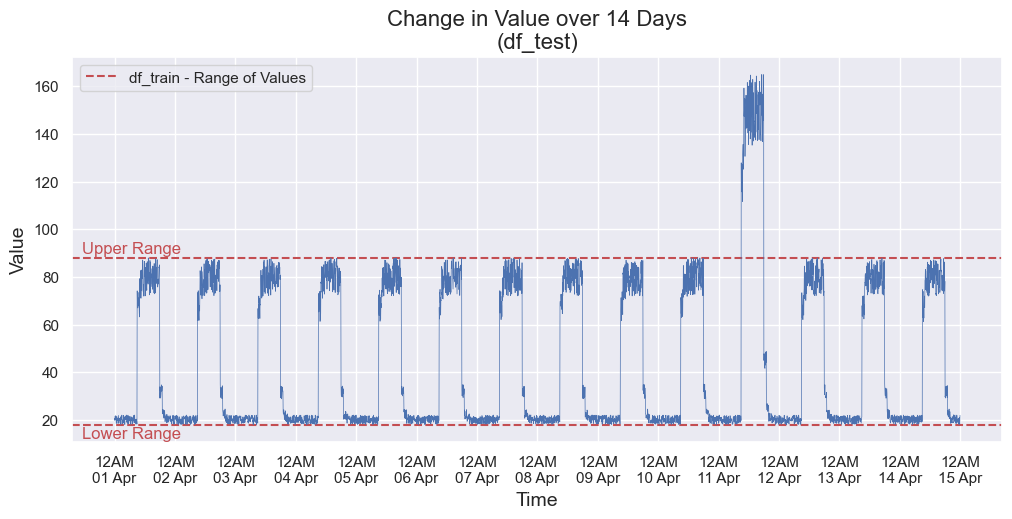

In [14]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Change in Value over 14 Days\n(df_test)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Show red lines at values train_df range.  
ax.axhline(y = 18, color = 'r', linestyle = '--', label = 'df_train - Range of Values')
ax.axhline(y = 88, color = 'r', linestyle = '--')

# Legend
plt.legend(loc='upper left')

# Plot upper and lower train_df range text. 
plt.text(0.01, .49, 'Upper Range', color = 'r', transform=ax.transAxes)
plt.text(0.01, .01, 'Lower Range', color = 'r', transform=ax.transAxes)

# Plot Value vs Time. 
plt.plot(df_test.index, df_test['value'], linewidth=0.5);

On `test_df`, Day 1-10 and 12-14 are all consistent with that of the `train_df` daily patterns. However, unlike `train_df`,  `test_df` has one day where there is a jump in the value data. This occurs on the 11th of April (Day 11). Lets look closer at Day 1 (no anomaly) versus Day 11 (anomaly). 

In [15]:
# Separate dfs for Day 1 and 11. 
df_test_day1 = df_test.iloc[0:288]
df_test_day11 = df_test.iloc[2880:3168]

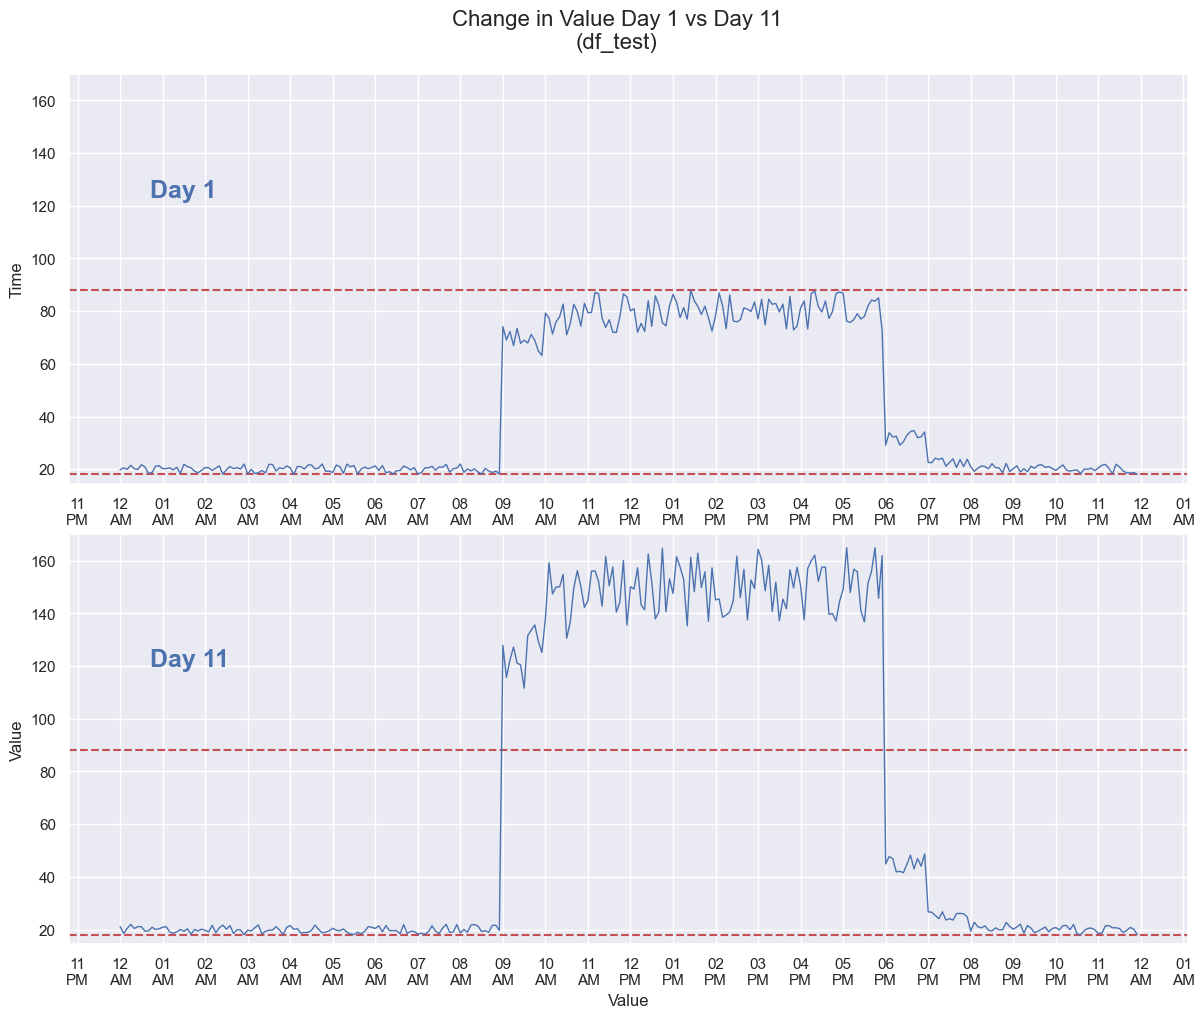

In [16]:
# Graph style
sns.set(style="darkgrid")

# Define the date format
date_form = mdates.DateFormatter("%I\n%p")

# Set up for 2 vertical plots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10))

# Add title
fig.suptitle("Change in Value Day 1 vs Day 11\n(df_test)", fontsize=16)
plt.tight_layout()

# Add Day 1 text
plt.text(0.0001, 1.99, 'Day 1', color = 'b', fontsize = 18, weight='bold', transform=ax.transAxes)

# Format date. 
ax1.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 hour intervals
ax1.xaxis.set_major_locator(mdates.HourLocator())

# Show red line at values normal range. 
ax1.axhline(y = 18, color = 'r', linestyle = '--')
ax1.axhline(y = 88, color = 'r', linestyle = '--')

# Set y limit. 
ax1.set_ylim(top=170)

# Set y-label. 
ax1.set_ylabel('Time')

# Plot Value vs Time. 
ax1.plot(df_test_day1.index, df_test_day1['value'], linewidth=1.0)

# Add Day 11 text
plt.text(0.0001, 0.77, 'Day 11', color = 'b', fontsize = 18, weight='bold', transform=ax.transAxes)

# Format date. 
ax2.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 hour intervals
ax2.xaxis.set_major_locator(mdates.HourLocator())

# Show red line at values normal range 
ax2.axhline(y = 18, color = 'r', linestyle = '--')
ax2.axhline(y = 88, color = 'r', linestyle = '--')

# Set y-label. 
ax2.set_xlabel('Value')

# Set y limit. 
ax2.set_ylim(top=170)

# Set y-label. 
ax2.set_ylabel('Value')

# Plot Value vs Time. 
ax2.plot(df_test_day11.index, df_test_day11['value'], linewidth=1.0);

On day 11 the range of values are much greater between 9AM - 7PM then they are on other days in both `test_df` and `train_df`. 

The purpose of the exercise is to train the model so that it is able to detect this anomaly in the timeseries data. 

<h3 style="color: #001a79;">Preprocessing</h3>

<hr style="border-top: 1px solid #001a79;" />

Data preprocessing is a process of preparing the raw data and making it suitable for a machine learning model. It is the first and crucial step while creating a machine learning model and is used in order to ensure the model works and enhance performance. 

Sources: 
<a href="https://www.javatpoint.com/data-preprocessing-machine-learning" target="_blank">Java T Point: Data Preprocessing in Machine learning</a> <br>
<a href="https://en.wikipedia.org/wiki/Data_pre-processing" target="_blank">Wikipedia: Data pre-processing
</a>


### Normalise `df_train`

Normalisation is a technique often applied as part of data preparation for machine learning. The goal of normalisation is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.

Below $x_2$ is the normalised value. $x_1$ is the old value. $\mu$ is the mean of `df_train`. $\sigma$ is the standard deviation of `df_train`. 

$$x_2 = \frac{x_1 - \mu}{\sigma}$$

Source: <a href="https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/normalize-data" target="_blank">Microsoft: Normalize Data component</a>

In [17]:
# Calculate the mean of values
train_mean = df_train['value'].mean()

# Calculate the standard deviation of values
train_std = df_train['value'].std()

print(f'Mean: {train_mean:.2f}')
print(f'Standard Deviation: {train_std:.2f}')

Mean: 42.44
Standard Deviation: 28.08


In [18]:
# Normalise df_train 
df_train_norm = (df_train - train_mean) / train_std
df_train_norm.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [19]:
# Print the min value
df_train_norm.min()

value   -0.870367
dtype: float64

In [20]:
# Print the max value
df_train_norm.max()

value    1.621882
dtype: float64

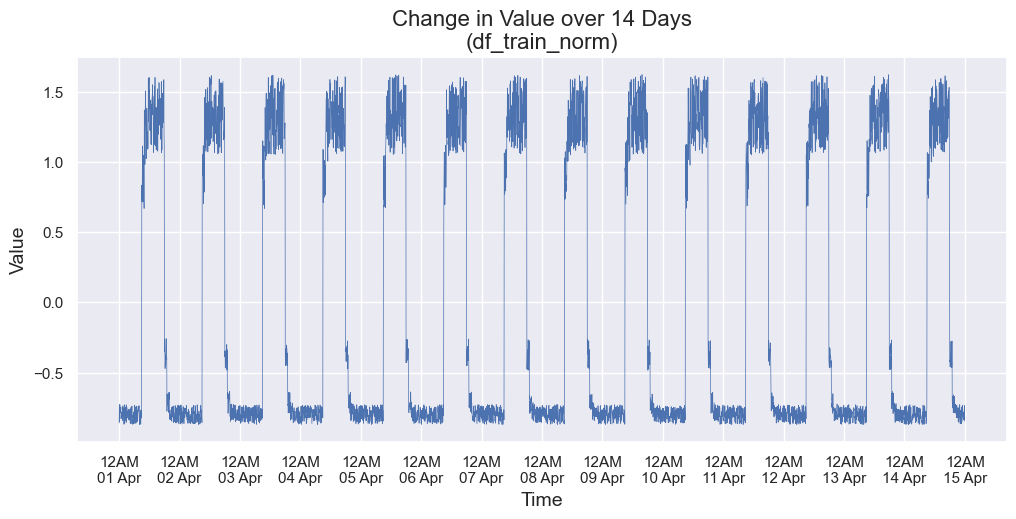

In [21]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Change in Value over 14 Days\n(df_train_norm)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Plot Time vs Value
plt.plot(df_train_norm.index, df_train_norm['value'], linewidth=0.5);

We can see that the y-scales range are now between -0.870367 and 1.621882. 

### Normalise `df_test`

Here we normalise `df_test` with the `df_train` mean and standard deviation. The reason for using the `df_train` mean and standard deviation is we will always have the mean and standard deviation of the training data but we will not always have it of data that is used on our model after creating it.  

Source: <a href="https://stats.stackexchange.com/a/495360" target="_blank">StackExchange: Why do we normalize test data on the parameters of the training data?</a>

In [22]:
# Normalise df_train 
df_test_norm = (df_test - train_mean) / train_std

### Reshaping the Data

#### How `splitBySize` works? 

In [23]:
# Split df into a 3D array 
def splitBySize(vals, N):
    # Empty list
    L = []
    # Loop through index 0 to the (length of vals - N + 1)
    for i in range(len(vals) - N + 1):
        # Separate vals into 2D arrays of length 1 x N
        L.append(vals[i:i+N])
    # Stack these arrays to create a 3D array
    return np.stack(L)

Take the `example_df` below where collumn `Nums` is 6 rows between 1 - 6.  

In [24]:
# Create a list 1-6
myList = [x for x in range(1,7)]

# Convert to a dataframe
example_df = pd.DataFrame(myList, columns=["Nums"])
example_df

,Nums
0,1
1,2
2,3
3,4
4,5
5,6


In [25]:
# Set size N to 3
n = 3

In [26]:
# Call splitBySize on example_df
df_split = splitBySize(vals = example_df, N = n)
df_split

array([[[1],
        [2],
        [3]],

       [[2],
        [3],
        [4]],

       [[3],
        [4],
        [5]],

       [[4],
        [5],
        [6]]], dtype=int64)

In [27]:
# Print shape
df_split.shape

(4, 3, 1)

`splitBySize(vals = example_df, N = n)`

[1, 2, 3, 4, 5, 6] is split 4 lists of size 3: <br><br>
[1, 2, 3], <br>
[2, 3, 4], <br>
[3, 4, 5], <br>
[4, 5, 6] <br> 

Which are further split into lists of size 1: <br>

[1, 2, 3] = [1], [2], [3] <br>
[2, 3, 4] = [2], [3], [4] <br>
[3, 4, 5] = [3], [4], [5] <br>
[4, 5, 6] = [4], [5], [6] <br> 

This results in a 3D list of 4 lists containing 3 lists of size 1. 

### Reshape `df_train`

As mentioned above, values were recorded for 14 days, every 5 minutes. Therefore: 
- Every hour 12 values are recorded. 
- Every day 288 values are recorded. 
- So in 14 days 4,032 values are recorded in total.

In [28]:
# The number of values recorded per day
day_size = 288

In [29]:
# Normalised training values
df_train_norm

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


In [30]:
x_train = splitBySize(df_train_norm, day_size)

In [31]:
print(x_train.shape)

(3745, 288, 1)


This splits `df_train_norm` into a 3D array of 3,745 lists containing 288 lists of size 1 that we will use for our training data. 

### Reshape `df_train`

In [32]:
x_test = splitBySize(df_test_norm, day_size)

<h3 style="color: #001a79;">Neural Networks</h3>

<hr style="border-top: 1px solid #001a79;" />

Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and used in deep learning algorithms. Their name and structure are inspired by the human brain, mimicking the way that biological neurons signal to one another. 

Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. 

<img src="Regular Tasks/content/neuralnetwork.PNG" alt="Neural Network" width="350px"/>

Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network. 

<img src="Regular Tasks/content/activationfunction.PNG" alt="Activation Function" width="450px"/>

Neural networks rely on training data to learn and improve their accuracy over time. 

Sources:<br>
<a href="https://www.ibm.com/topics/neural-networks" target="_blank">IBM: Neural Networks</a> <br> 
<a href="https://www.youtube.com/watch?v=aBIGJeHRZLQ&ab_channel=KeithGalli" target="_blank">Keith Galli (YouTube): Introduction to Neural Networks in Python (what you need to know) | Tensorflow/Keras</a>.

### The Convolutional Reconstruction Autoencoder Model

As mentioned above the anomaly detection algorithm used in this notebook is the Convolutional Reconstruction Autoencoder Model. 

Convolution Neural Networks (CNN) are a type of neural network that can uncover key information in both time series and image data. For this reason, it is highly valuable for pattern recognition, image-related tasks, such as image recognition, and object classification. To identify patterns within a time series, a CNN leverages principles from linear algebra, such as matrix multiplication. 

An autoencoder is a type of artificial neural network used to learn data encodings in an unsupervised manner. The aim of an autoencoder is to learn a lower-dimensional representation (encoding) for a higher-dimensional data, typically for dimensionality reduction, by training the network to capture the most important parts of the input. 

There are 3 parts of autoencoders: 

1. Encoder: compresses the train-validate-test set input data into an encoded representation that is typically several orders of magnitude smaller than the input data. 
2. Bottleneck: contains the compressed knowledge representations and is therefore the most important part of the network.
3. Decoder: helps the network 'decompress' the knowledge representations and reconstructs the data back from its encoded form. The output is then compared with a ground truth. 

<img src="Regular Tasks/content/autoencoder.PNG" alt="Autoencoder " width="350px"/>

### Our Model 

<img src="Regular Tasks/content/model2.PNG" alt="Model " width="750px"/>

Above is an image of the model. it consists of:

1. The input layer.
2. The hidden layers. 
3. The output layer. 

#### 1. Input Layer 

Above we used `splitBySize()` to split `df_train_norm` into an array of (3745, 288, 1). Each of the 3745 arrays of shape (288, 1) will be inputted here. 

#### 2. Hidden Layers 

#### 1D Convolutional Layers

In a 1D convolutional layer, a kernel slides along one dimensional input data, in our example the kernals are size 7 with strides 2. As seen below: 

<img src="Regular Tasks/content/kernals.PNG" alt="Activation Function" width="450px"/> 

Setting 'padding' = 'same' results in padding (i.e. adding) nodes evenly to the left/right of the input so that the output has the same dimension as the input. However, because our strides are 2 we get half the input, meaning we get (144, 1) in the first convolutional layer in our model. Filter is the dimensionality of the output space (i.e. the number of output filters in the convolution). This results in an array shaped (144, 32) in the first convolutional layer as filter = 32. 

The second convolutional layer is located after the first dropout layer that is shaped (144, 32). It has kernals of size 7, strides of 2 and 'padding' = 'same'. This results in half the nodes of the first convolutional layer. Filter is set to 16 meaning the shape of the second convolutional layer is (72, 16). 

Activation functions introduce non-linearity into our neural net calculations (Basically adds complexity to the value output). This allows us to fit more complex data and compute more complex things. ReLU (Rectified Linear Unit) is the most commonly used activation function in deep learning. The function returns 0 if the input is negative, but for any positive input, it returns that value back. 

<img src="Regular Tasks/content/AFtypes.PNG" alt="Activation Function Types" width="450px"/> 

#### Dropout Rate

Dropout is a technique where randomly selected neurons are ignored during training. Dropout rate is the probability nodes are randomly disconnected during training steps. The Dropout layer randomly sets input units to 0 with a frequency of rate 0.2 at each step during training time, which helps prevent overfitting. In our model, drop out layer are set after the first 1D convolutional layer and first 1D Convolutional Transposed Layer. 

#### 1D Transposed Convolutional Layers:

A transposed convolutional layer is usually carried out for upsampling i.e. to generate an output feature map that has a spatial dimension greater than that of the input feature map. Just like the standard convolutional layer, the transposed convolutional layer is also defined by the padding and stride. 

The first 1D transposed convolutional layer, is located after the second 1D convolutional layer. It changes the shape from (72, 16) to (144, 16) as padding = "same", stride = 2 (doubles in size rather than halfs) and filter = 16. 

The second 1D transposed convolutional layer, is located after the second drop out layer. It changes the shape from (144, 16) to (288, 32) as padding = "same" and stride = 2 and filter = 32. 

The third and last 1D transposed convolutional layer is the output layer. This is shaped (288, 1) as padding = "same" and stride = 1 by default. Filter is set to 1 return the same shape as the input layer.

Sources: <br>
<a href="https://keras.io/api/layers/convolution_layers/convolution1d/" target="_blank">Keras: Conv1D layer</a> <br>
<a href="https://keras.io/api/layers/convolution_layers/convolution1d/" target="_blank">Keras: Dropout layer</a> <br>
<a href="https://keras.io/api/layers/convolution_layers/convolution1d_transpose/" target="_blank">Keras: Conv1DTranspose layer</a> <br>
<a href="https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610" target="_blank">Towards Data Science: Understanding 1D and 3D Convolution Neural Network | Keras</a> <br>
<a href="https://wandb.ai/krishamehta/seo/reports/Difference-Between-SAME-and-VALID-Padding-in-TensorFlow--VmlldzoxODkwMzE" target="_blank">Weights and Biases: Difference Between ‘SAME’ and ‘VALID’ Padding in TensorFlow</a> <br>
<a href="https://www.v7labs.com/blog/autoencoders-guide" target="_blank">V7: Autoencoders in Deep Learning: Tutorial and Use Cases [2022]</a> <br>
<a href="https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea" target="_blank">Towards Data Science: Anomaly Detection using Autoencoders</a> <br>
<a href="https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6" target="_blank">Towards Data Science: Activation Functions</a><br>
<a href="https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11" target="_blank">Towards Data Science: What is Transposed Convolutional Layer?</a>



In [33]:
# Create layers of neural network
layers = [
    # Add input layer
    keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    
    # Add first Conv1D layer 
    keras.layers.Conv1D(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    
    # Add dropout layer on Conv1D layer 
    keras.layers.Dropout(rate=0.2),
    
    # Add second Conv1D layer 
    keras.layers.Conv1D(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    
    # Add first Conv1DTranspose layer 
    keras.layers.Conv1DTranspose(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    
    # Add dropout layer on Conv1DTranspose layer 
    keras.layers.Dropout(rate=0.2),
    
    # Add second Conv1DTranspose layer 
    keras.layers.Conv1DTranspose(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    
    # Add third Conv1DTranspose layer which is the output layer
    keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [34]:
# Sequential stacks layers to create the model.
model = keras.Sequential(layers)

### Compiling the Model

Compiling a model is required to finalise the model and make it completely ready to use. For compilation, we need to specify an optimizer and a loss function. 

#### Optimizer

Optimizers define how neural networks learn. Gradient Descent was the original optimizer. It involves taking small steps iteratively until we reach the correct weights in the model. However, the problem is that the weights only update once after seeing the whole dataset. 

Stochastic Gradient Descent update the weights after seeing each dataset instead of seeing the entire dataset instead of the whole dataset. However, this also has a problem, because it is influenced by every single sample the weights jump around a lot. 

The Adam (Adaptive Moment Estimation) optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing. Learning rate is a hyperparameter of the optimizer that controls how much to change the model in response to the estimated error each time the model weights are updated.

Source: <br> 
<a href="https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/" target="_blank">Machine Learning Mastery: Gentle Introduction to the Adam Optimization Algorithm for Deep Learning</a> <br>
<a href="https://www.youtube.com/watch?v=mdKjMPmcWjY&ab_channel=CodeEmporium" target="_blank">CodeEmporium (YouTube): Optimizers - EXPLAINED!</a>

In [35]:
# Set optimizer as Adam with learning rate 0.001
optimizer = keras.optimizers.Adam(learning_rate=0.001)

#### Loss Function 

A loss function in Machine Learning is a measure of how accurately the model is able to predict the expected outcome. The loss fuction will take the predicted values (values that are outputted) of the model and the expected values. The output of the loss function is called the loss which is a measure of how well the model did at predicting the ourcome. 

High value - the model performed poorly. <br>
Low value - the model performed well. 

The Mean Squared Error (MSE) loss function is used to compute the mean square of errors between the predictions and the true values. 

$$MSE = \frac{1}{n}\sum_{j=1}^{n}(y_j - \hat{y}_j)^2$$ 

Source: <a href="https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3" target="_blank">Towards Data Science: Loss Functions</a>

In [36]:
# Compile model 
model.compile(optimizer=optimizer, loss="mse")

### Summary of the Model

In [37]:
# Get model summary of layers, shape and parameters. 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

### Training the Model 

Now that the model is built we can train the model. In this example we will use x = `x_train` and y = `x_train`. `x_train` are the values that do not contain any anomalies in data. So we are training the model to know what the values should be. 

In [39]:
# Train the model by fitting it using df_train as input and output. 
history = model.fit(
    x_train,
    x_train,
    
    # Epochs is the number of times we go through the training data
    epochs=50,
    
    # Batch size is the number of values passing through the network at each step. 
    batch_size=128,
    
    # Fraction of training data that will be used for validation.
    validation_split=0.1,
    
    # Stop training the model if val_loss has no improvement within 5 epochs (i.e. val_loss stops decreasing)
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 4s 134ms/step - loss: 0.0201 - val_loss: 0.0204
Epoch 2/50
27/27 [==============================] - 3s 107ms/step - loss: 0.0195 - val_loss: 0.0240
Epoch 3/50
27/27 [==============================] - 3s 112ms/step - loss: 0.0188 - val_loss: 0.0227
Epoch 4/50
27/27 [==============================] - 3s 111ms/step - loss: 0.0182 - val_loss: 0.0237
Epoch 5/50
27/27 [==============================] - 3s 106ms/step - loss: 0.0177 - val_loss: 0.0263
Epoch 6/50
27/27 [==============================] - 3s 123ms/step - loss: 0.0171 - val_loss: 0.0248


<h3 style="color: #001a79;">Evaluation</h3>

<hr style="border-top: 1px solid #001a79;" />

### Training Loss and Validation Loss

The training loss is a metric used to assess how the model fits the training data. It is measured at every batch (in this case 128 values) by taking the sum of errors for each example in the training set. 

In [41]:
training_loss = history.history["loss"]

Validation loss is a metric to assess the performance of the models validation set. The validation set is a proportion of the model set aside (10%) to validate the performance of the model. The validation loss is similar to the training loss and is calculated from a sum of the errors for each example in the validation set.

In [42]:
validation_loss = history.history["val_loss"]

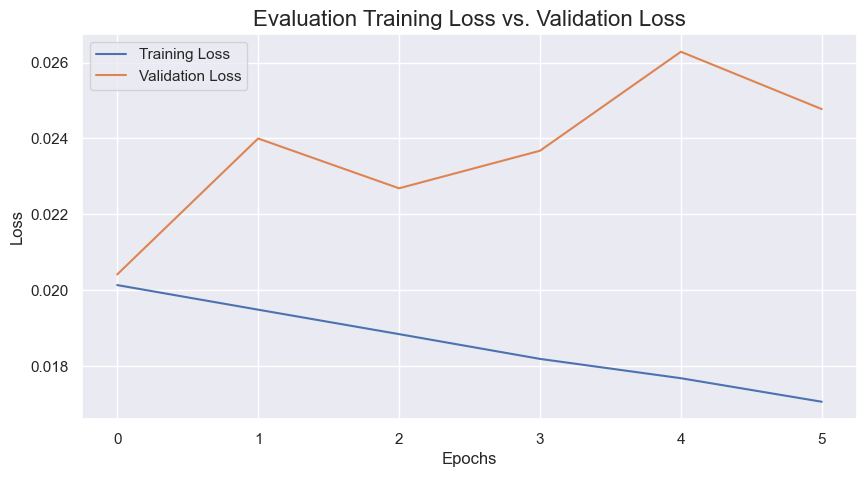

In [43]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 5))

# Add title
plt.title("Evaluation Training Loss vs. Validation Loss", fontsize=16)

# Set labels
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");

# Plot training loss at each epoch
ax.plot(training_loss, label="Training Loss")

# Plot validation loss at each epoch
ax.plot(validation_loss, label="Validation Loss")

# Add legend 
ax.legend();

The training loss and validation loss both decrease and stabilize at a specific point. This indicates an optimal fit, i.e a model that does not overfit or underfit. 

Source: <a href="https://www.baeldung.com/cs/training-validation-loss-deep-learning#:~:text=The%20training%20loss%20is%20a,to%20initially%20train%20the%20model" target="_blank">Baeldung: Training and Validation Loss in Deep Learning</a>

### Predicted Values `x_train`

Now that we have our model we can see what the model predicts if the training data was inputted. 

In [44]:
# Get the prediction values for x_train.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 2ms/step


In [45]:
# Shape of output  
x_train_pred.shape

(3745, 288, 1)

Earlier in the notebook, we normalised and reshaped `df_train` in order to preprocess it for training the model. This means the output of the data is normalised and shaped in this way. 

We will start by undoing the reshaping: 

In [46]:
# Get the start index for each day. 
day_ind = [x for x in range(0, 4031, 288)]
day_ind

[0, 288, 576, 864, 1152, 1440, 1728, 2016, 2304, 2592, 2880, 3168, 3456, 3744]

Get the 14 days values: 

In [48]:
# Empty list
x_train_pred_reduced = []

# Undo `splitBySize()` to get 14 days 288 values
for i in day_ind:
    x_train_pred_reduced.append(x_train_pred[i])
x_train_pred_reduced = np.array(x_train_pred_reduced)
x_train_pred_reduced.shape

(14, 288, 1)

Flatten the 3D array to a 1D array

In [48]:
x_train_pred_reduced = x_train_pred_reduced.flatten()
x_train_pred_reduced.shape

(4032,)

Earlier we saw how to normalize the values. 

$x_2$ is the normalised value. $x_1$ is the old value. $\mu$ is the mean of `df_train`. $\sigma$ is the standard deviation of `df_train`. 

$$x_2 = \frac{x_1 - \mu}{\sigma}$$

We can reverse by: 

$$x_1 = {x_2 \sigma} + \mu$$

In [49]:
x_train_pred_denorm = (x_train_pred_reduced * train_std) + train_mean

Create a new df we predicted values. 

In [50]:
x_train_pred_denorm_df = pd.DataFrame(data = x_train_pred_denorm, index=df_train.index, columns=["value"])
x_train_pred_denorm_df

,value
timestamp,
2014-04-01 00:00:00,29.207966
2014-04-01 00:05:00,26.798117
2014-04-01 00:10:00,24.002119
2014-04-01 00:15:00,23.660063
2014-04-01 00:20:00,22.114565
...,...
2014-04-14 23:35:00,19.954666
2014-04-14 23:40:00,20.982803
2014-04-14 23:45:00,22.705679


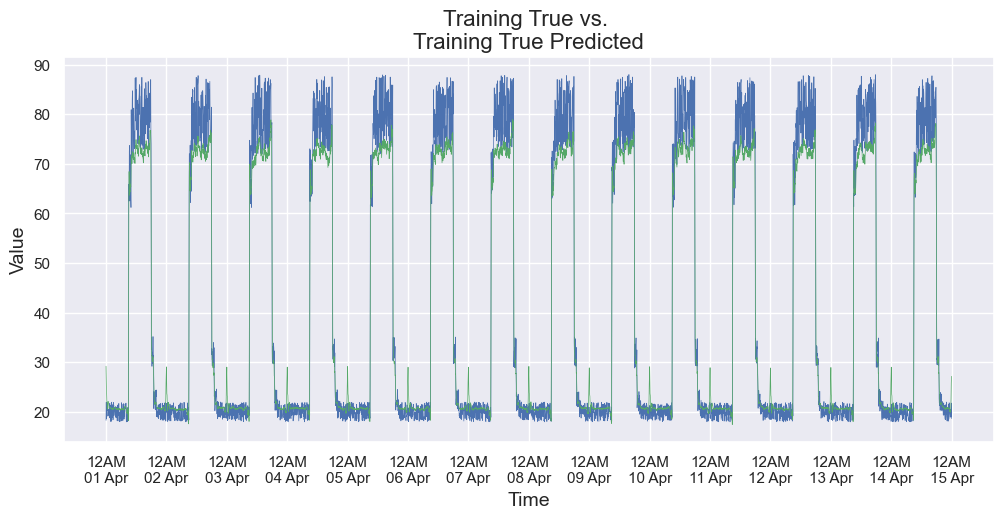

In [51]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Training True vs. \nTraining True Predicted", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Plot Value vs Time.
plt.plot(df_train.index, df_train['value'], linewidth=0.5)
plt.plot(x_train_pred_denorm_df.index, x_train_pred_denorm_df['value'], color = "g",linewidth=0.5);

We can see the predicted values follow the same pattern each day as `df_train`. 

In [52]:
# Get df for day 1
x_train_day1_pred_denorm_df = x_train_pred_denorm_df.iloc[0:288]

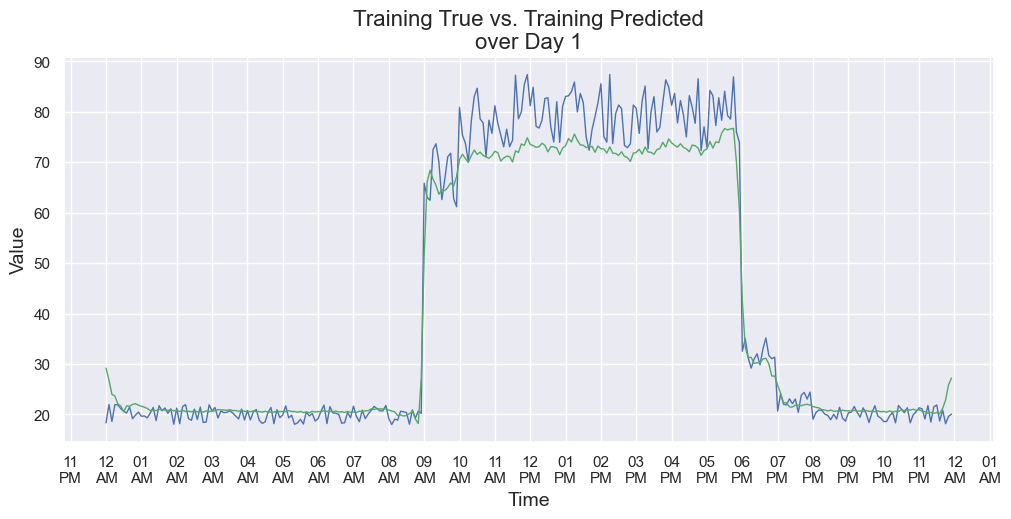

In [53]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Training True vs. Training Predicted\nover Day 1", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("%I\n%p")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.HourLocator())

# Plot Time vs Value
plt.plot(df_train_day1.index, df_train_day1['value'], linewidth=1.0)
plt.plot(x_train_day1_pred_denorm_df.index, x_train_day1_pred_denorm_df['value'], color = "g", linewidth=1.0);

Looking closer we can see that the predicted values do not fluctuate as much as the true values. However, this is expected as the model is trying to make the best estimate possible. 

<h3 style="color: #001a79;">Anomaly Detection</h3>

<hr style="border-top: 1px solid #001a79;" />

### Mean Absolute Error (MAE)

Like Mean Squared Error (MSE), Mean Absolute Error (MAE) is another type of loss function. While the MSE squares the errors and calculates the average. The MAE takes the absolute value of the errors and then calculates the average. Since we are taking the absolute value using the MAE, all of the errors will be weighted on the same linear scale. 

$$MAE = \frac{1}{n}\sum_{j=1}^{n}|y_j - \hat{y}_j|$$ 

In [54]:
# Calculate MAE loss for x train predictions values 
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
train_mae_loss.shape

(3745, 1)

### MAE Threshold

In [55]:
# Get reconstruction loss threshold - the max MAE loss.
threshold = np.max(train_mae_loss)

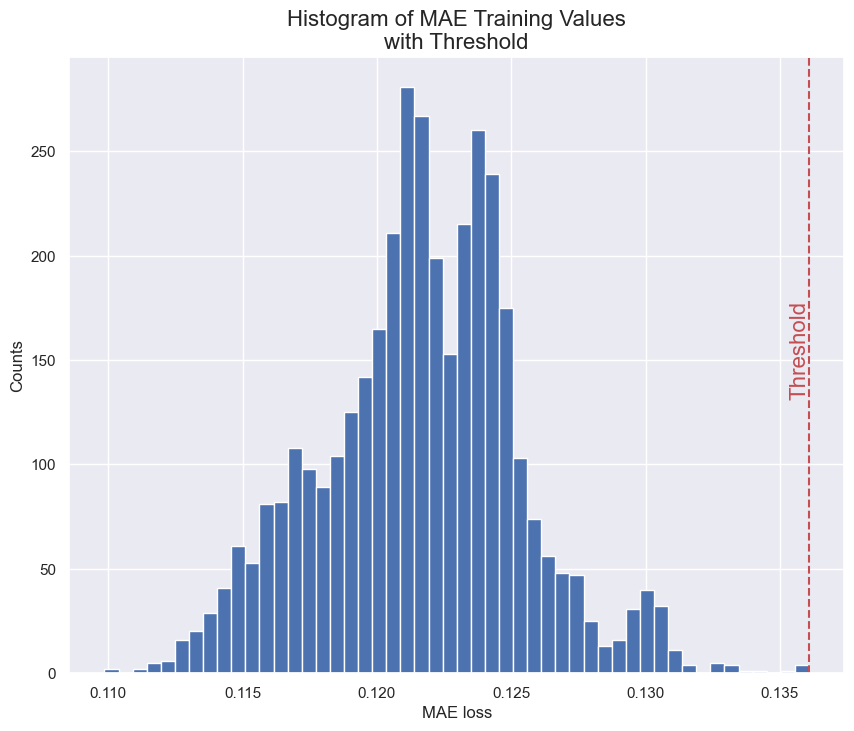

In [56]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Add title
plt.title("Histogram of MAE Training Values\nwith Threshold", fontsize=16)

# Histogram of MAE loss values 
ax.hist(train_mae_loss, bins=50)

# Plot vertical line at threshold 
ax.axvline(x = threshold, color = 'r', linestyle = '--')

# Plot threshold text
plt.text(0.93, .45, 'Threshold', color = 'r', rotation=90, fontsize=16, transform=ax.transAxes)

# Set x and y labels.
ax.set_xlabel("MAE loss")
ax.set_ylabel("Counts");

In Anomaly Detection, Autoencoders try to minimize the reconstruction error as part of its training. Anomalies are detected by checking the magnitude of the reconstruction loss.

Threshold is set to the max MAE loss value from the `x_train`. Data points in the test data where their reconstruction loss is higher than the fixed threshold are anomalies. 

Source: <a href="https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea" target="_blank">Towards Data Science: Anomaly Detection using Autoencoders</a> <br>

### Test Model

Now we can test our model on the test data. 

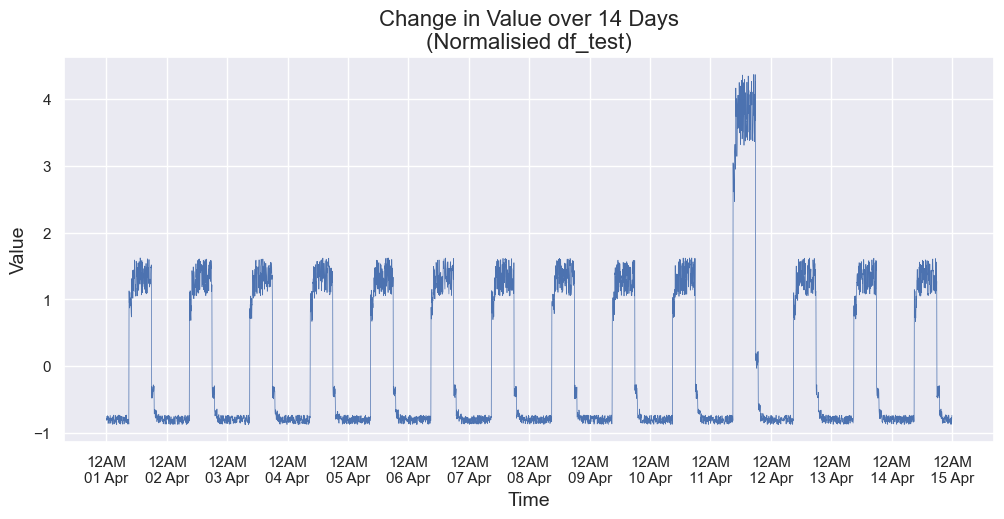

In [57]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Change in Value over 14 Days\n(Normalisied df_test)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))


# Plot Time vs Value
plt.plot(df_test_norm.index, df_test_norm['value'], linewidth=0.5);

In [58]:
# Shape of x test
x_test.shape

(3745, 288, 1)

### Predicted Values `x_test`

In [59]:
# Get the prediction values for x_test.
x_test_pred = model.predict(x_test)

118/118 [==============================] - 0s 2ms/step


In [60]:
# Shape of output
x_test_pred.shape

(3745, 288, 1)

### `x_test` MAE values 

In [61]:
# Calculate MAE loss for x test predictions values 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

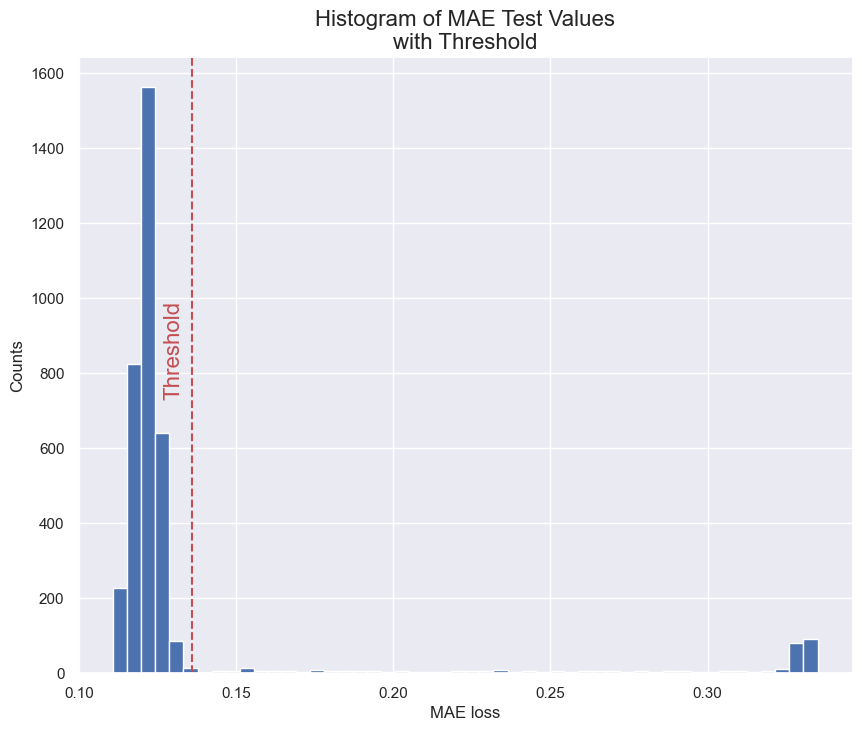

In [62]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Add title
plt.title("Histogram of MAE Test Values\nwith Threshold", fontsize=16)

# Histogram of MAE loss values 
ax.hist(test_mae_loss, bins=50)

# Plot vertical line at threshold 
ax.axvline(x = threshold, color = 'r', linestyle = '--')

# Plot threshold text
plt.text(0.11, .45, 'Threshold', color = 'r', rotation=90, fontsize=16, transform=ax.transAxes)

# Plot x and y labels.
ax.set_xlabel("MAE loss")
ax.set_ylabel("Counts");

From the histogram we can see the test data has MAE loss values greater than threshold. 

### Find Anomalies

In [63]:
# Detect all test_mae_loss which are anomalies.
anomalies = test_mae_loss > threshold
anomalies

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [64]:
anomalies.shape

(3745, 1)

In [65]:
# Empty list to store indexes of anomalies. 
inds = []

# Loop through each day_size window of anomalies. If all are True add i to inds. 
for i in range(day_size - 1, len(df_test_norm) - day_size + 1):
    if np.all(anomalies[i - day_size + 1 : i]):
        inds.append(i)

In [66]:
# Create df with anomalies only
df_anomaly = df_test.iloc[inds]

In [67]:
df_anomaly

,value
timestamp,
2014-04-11 09:05:00,115.705719
2014-04-11 09:10:00,122.386410
2014-04-11 09:15:00,127.261178
2014-04-11 09:20:00,121.157997
2014-04-11 09:25:00,120.468468
...,...
2014-04-11 17:35:00,151.380135
2014-04-11 17:40:00,156.009099
2014-04-11 17:45:00,164.947481


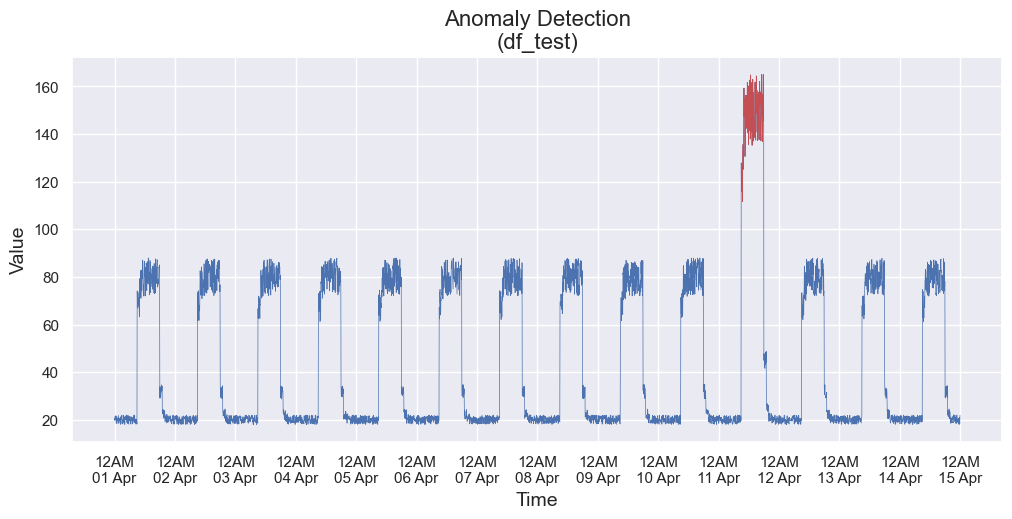

In [68]:
# Set figure size
fig, ax = plt.subplots(figsize=(12,5))

# Add title
plt.title("Anomaly Detection\n(df_test)", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Plot Time vs Value
plt.plot(df_test.index, df_test['value'], linewidth=0.5);

# Plot Time vs Value
plt.plot(df_anomaly.index, df_anomaly['value'], linewidth=0.5, color="r");

Above we can see the anomaly data points in red (`df_anomaly`) plotted on top of the `df_test` values. 

### Conclusion 

We trained `df_train` on the model to be able to predict a regular pattern in the data. 

We used the model to predict the values of `df_train`. 

We calculated the MAE loss threshold of `df_train` - the max MAE loss of `df_train`. 

We then ran the test data on the model to predict their values and calculated the MAE loss. 

MAE loss values greater than the threshold were marked as anomalies. 